## Homework 4: Mean Shift Segmentation

**Due date:** May 4, 2023

The goal of the assignment is to implement the mean shift algorithm and use it for image segmentation. You should return the completed notebook, including answers and illustrations. 


**Part 1: mean shift on synthetic data**

* Generate a synthetic dataset of 100 2D points, containing 60 points sampled from a Gaussian distribution of unit covariance centered in (0,0) and 40 points sampled from a Gaussian with unit covariance centered in (4,4). Visualize your data.
* Implement a function that computes $G(x) = g(\|x\|^2/h^2)$ where $x \in \mathbb R^d$, $h$ is a bandwidth parameter and $g$ is the negative derivative of the Gaussian kernel or of the Epanechnikov kernel (see eq. 5.36 in Szeliski).  Plot $G(x)$ for $d=1$.
* Implement a function `MS_step` that takes as input a starting point `x`, a set of data points `data`, and a bandwidth `h` and returns the updated position of the point `x` after one step of the mean-shift algorithm.
* Implement the function `MS_point` which iterates `MS_step` until convergence (i.e., when the estimate changes by less than a small constant). Test it on your synthetic data and visualize the results.
* Implement the full mean shift algorithm by iterating `MS_point` on all the points, and merging modes for which distance is less than some constant. It should return a list of the modes and a label (corresponding to a mode) for each point. Visualize your results.
* Modify the previous code by allowing for a "bandwidth vector" $h \in \mathbb R^d$ that defines a different scale for each dimension of the input (this is because for segmentation we will use a different bandwidth for space and color). Note that you should also modify the convergence and merging conditions to consider this non-isotropic scaling.
* Experiment with your code by changing the data distribution, the kernel, and and bandwidth vector.

**Part 2: mean shift for image segmentation**

* For image segmentation, we will use the "Lab" color space because it approximates the way humans perceive color better than RGB. Load the image `veggies_small.jpg` (download from <a href="https://drive.google.com/file/d/1QECmvrczTR4ezTvkQMZyDuLjFNquFatX/view?usp=sharing">here</a>), and convert it to the Lab colorspace using the command `rgb2lab`. What is the range of the colorvalues in Lab? 
* Convert the (N,M,3) image into an (NM,5) matrix including color and position information for each point (tip: use the `np.meshgrid` function). What do you think might be a good choice for a bandwidth vector $h$?
* Use your mean shift code from the previous section to compute a meaningful segmentation of the image. Visualize the results as an image by replacing the color values of the pixels associated with each mode by the color of the mode. You can also try our algorithm on other (small) images.

In [2]:
import math
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
from skimage.color import rgb2lab,lab2rgb

Generate a synthetic dataset of 100 2D points, containing 60 points sampled from a Gaussian distribution of unit covariance centered in (0,0) and 40 points sampled from a Gaussian with unit covariance centered in (4,4). Visualize your data.

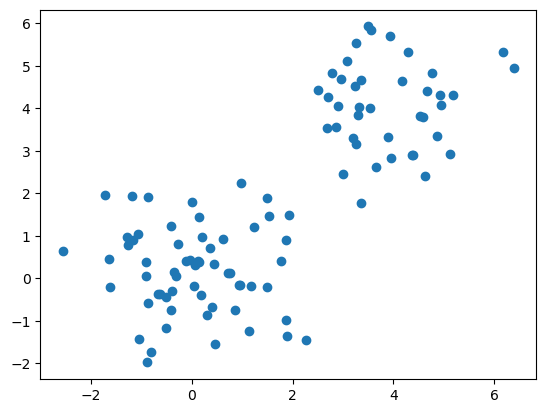

In [3]:
max_iter = 1000
np.random.seed(0)

# generating the synthetic dataset
mean1 = np.zeros(2)
cov1 = np.eye(2) # unit covariance, np.eye: return a 2d array with ones on the diagonal and zeros elsewhere
mean2 = np.array([4, 4]) 
cov2 = np.eye(2) # unit covariance
# draw random samples from a multivariate normal distribution
data1 = np.random.multivariate_normal(mean1, cov1, size = 60) # 60 points sampled from a Gaussian distribution of unit covariance centered in (0, 0)   
data2 = np.random.multivariate_normal(mean2, cov2, size = 40) # 40 points sampled from a Gaussian with unit covariance centered in (4, 4)
data = np.vstack([data1, data2])

# visualizing the dataset
plt.scatter(data[:, 0], data[:, 1])
plt.show()

Implement a function that computes $G(x) = g(\|x\|^2/h^2)$ where $x \in \mathbb R^d$, $h$ is a bandwidth parameter and $g$ is the negative derivative of the Gaussian kernel or of the Epanechnikov kernel (see eq. 5.36 in Szeliski).  Plot $G(x)$ for $d=1$.

computer vision, ponce p.274
\begin{align*}
K(x, h) &= \frac{(2\pi) ^ {-d / 2}}{h ^ d}\exp\left(-\frac{1}{2}\frac{\|x\| ^ 2}{h}\right)\\
\frac{\partial K(x, h)}{\partial x} &= \left(-\frac{1}{2}\frac{2\|x\|}{h}\right)\frac{(2\pi) ^ {-d / 2}}{h ^ d}\exp\left(-\frac{1}{2}\frac{\|x\| ^ 2}{h}\right)\\
&= -\frac{\|x\|}{h}\frac{(2\pi) ^ {-d / 2}}{h ^ d}\exp\left(-\frac{1}{2}\frac{\|x\| ^ 2}{h}\right)\\
\end{align*}

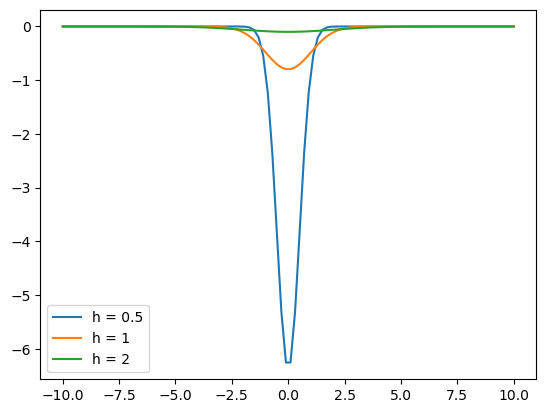

In [4]:
def kernel(x, h, derivative = "gaussian"):
    norm_x = np.linalg.norm(x) ** 2 / h ** 2
    if derivative == "gaussian":
        g = -2 * np.exp(-0.5 * norm_x) / (np.sqrt(2 * np.pi) * h ** 3) # Fukunaga 1975, p.30
    elif derivative == "epanechnikov":
        if norm_x < 1:
            g = -3 / (4 * np.pi * h ** 5) * (1 - norm_x) # Fukunaga 1975, p.30
        else:
            g = 0
    return g

x_range = np.linspace(-10, 10, 100)
h_values = [0.5, 1, 2]

for h in h_values:
    g_values = [kernel(np.array([x]), h) for x in x_range]
    plt.plot(x_range, g_values, label = f"h = {h}")
plt.legend()
plt.show()

Implement a function `MS_step` that takes as input a starting point `x`, a set of data points `data`, and a bandwidth `h` and returns the updated position of the point `x` after one step of the mean-shift algorithm.

In [5]:
def MS_step(x, data, h):
    num = 0
    denom = 0
    for i in range(data.shape[0]):
        diff = (x - data[i]) / h
        k = kernel(diff, h)
        num += k * data[i]
        denom += k
    return num / denom

Implement the function `MS_point` which iterates `MS_step` until convergence (i.e., when the estimate changes by less than a small constant). Test it on your synthetic data and visualize the results.

In [6]:
def MS_point(x, data, h, eps = 1e-5):
    while True:
        x_new = MS_step(x, data, h)
        # print('x_new', x_new)
        if np.linalg.norm(x_new - x) < eps:
            break
        x = x_new
    return x_new

Implement the full mean shift algorithm by iterating `MS_point` on all the points, and merging modes for which distance is less than some constant. It should return a list of the modes and a label (corresponding to a mode) for each point. Visualize your results.

In [12]:
def mean_shift(data, h, eps = 1e-5, dist_thresh = 0.1):
    modes = []
    labels = np.zeros(data.shape[0], dtype = int)
    for i in range(data.shape[0]):
        print(f'data[{i}] = {data[i]}')
        if labels[i] == 0:
            x = MS_point(data[i], data, h)
            # print('x = ', x)
            label = len(modes) + 1
            for j in range(len(modes)):
                # print(f'mode[{j}] = {modes[j]}')
                if np.linalg.norm(x - modes[j]) < dist_thresh * np.sum(h):
                    label = j + 1
                    break
            modes.append(x)
            labels[i] = label
    return modes, labels

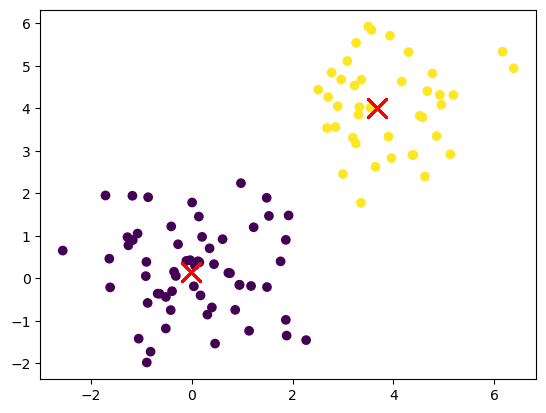

In [8]:
modes, labels = mean_shift(data, h = np.array([1, 1]))
plt.scatter(data[:, 0], data[:, 1], c = labels)
plt.scatter([m[0] for m in modes], [m[1] for m in modes], marker = "x", s = 200, color = "red")
plt.show()
modes, labels = mean_shift(data, h = np.array([0.5, 1.5]))

For image segmentation, we will use the "Lab" color space because it approximates the way humans perceive color better than RGB. Load the image `veggies_small.jpg` (download from <a href="https://drive.google.com/file/d/1QECmvrczTR4ezTvkQMZyDuLjFNquFatX/view?usp=sharing">here</a>), and convert it to the Lab colorspace using the command `rgb2lab`. What is the range of the colorvalues in Lab? 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Lab Image')

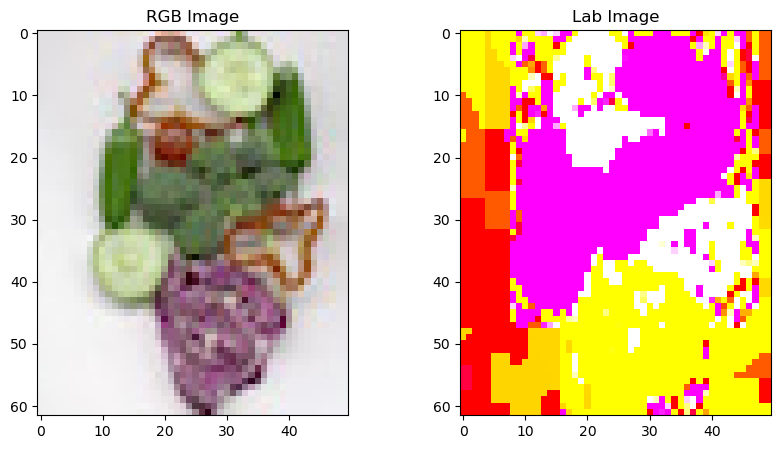

In [9]:
from skimage import io, color

img = io.imread('veggies_small.jpg')
img_lab = color.rgb2lab(img)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.imshow(img)
ax1.set_title('RGB Image')

# Plot the Lab image
ax2.imshow(img_lab)
ax2.set_title('Lab Image')

Convert the (N,M,3) image into an (NM,5) matrix including color and position information for each point (tip: use the `np.meshgrid` function). What do you think might be a good choice for a bandwidth vector $h$?

In [10]:
N, M, _ = img_lab.shape
x, y = np.meshgrid(np.arange(M), np.arange(N))
xy = np.column_stack([img_lab.reshape(N*M, 3), x.reshape(N*M), y.reshape(N*M)])
print(xy)

[[89.05178892  1.21117293 -1.22096119  0.          0.        ]
 [89.05178892  1.21117293 -1.22096119  1.          0.        ]
 [89.05178892  1.21117293 -1.22096119  2.          0.        ]
 ...
 [95.34656791  1.21980719 -2.28168737 47.         61.        ]
 [95.34656791  1.21980719 -2.28168737 48.         61.        ]
 [95.34656791  1.21980719 -2.28168737 49.         61.        ]]


Use your mean shift code from the previous section to compute a meaningful segmentation of the image. Visualize the results as an image by replacing the color values of the pixels associated with each mode by the color of the mode. You can also try our algorithm on other (small) images.

In [20]:
print('len(data) = ', len(data))
modes, labels = mean_shift(xy[:6], h)

# Replace the color values of the pixels associated with each mode by the color of the mode
segmented_img = np.zeros_like(img_lab)
for i, mode in enumerate(modes):
    if i > 2: break
    mask = labels == i
    segmented_img[mask] = mode[:3]
    # print(segmented_img[mask])

# Convert back to RGB colorspace for visualization
segmented_img_rgb = color.lab2rgb(segmented_img)

len(data) =  100
data[0] = [89.05178892  1.21117293 -1.22096119  0.          0.        ]
data[1] = [89.05178892  1.21117293 -1.22096119  1.          0.        ]
data[2] = [89.05178892  1.21117293 -1.22096119  2.          0.        ]
data[3] = [89.05178892  1.21117293 -1.22096119  3.          0.        ]
data[4] = [89.0003171   0.8521265  -0.24520085  4.          0.        ]
data[5] = [ 8.95061001e+01  1.52737711e+00 -4.31206089e-03  5.00000000e+00
  0.00000000e+00]


AttributeError: 'list' object has no attribute 'shape'

NameError: name 'segmented_img_rgb' is not defined

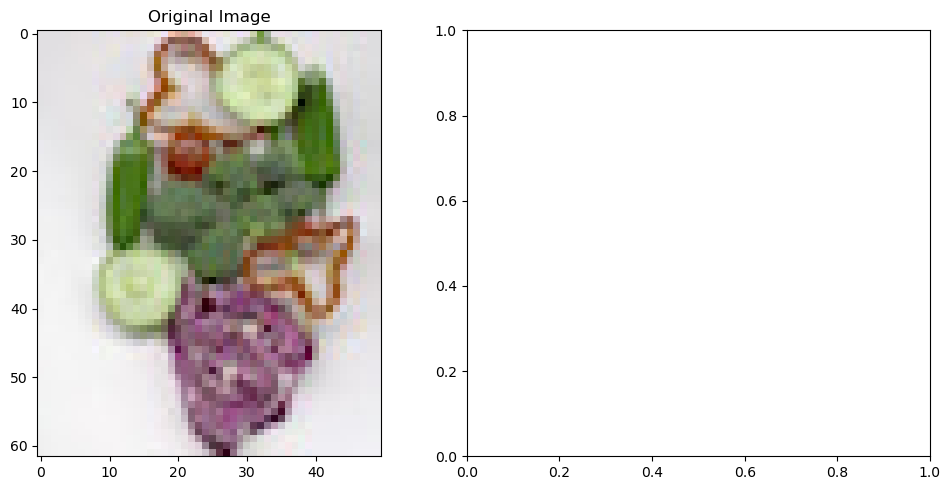

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[1].imshow(segmented_img_rgb)
axs[1].set_title('Segmented Image')
plt.show()